In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
from ast import literal_eval
import re
import pickle
import collections
import warnings
warnings.filterwarnings('ignore')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
with open('class-map-10.json', 'r') as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

In [3]:
# irmas genre information: country-folk ([cou_fol]), classical ([cla]), pop-rock ([pop-roc]), latin-soul ([lat-sou]).
aligned_genre = ['pop_roc', 'jazz_blue', 'classical', 'country_folk', 'latin_soul']

In [4]:
# load embeddings
embeddings = h5py.File('embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys


# irmas

In [5]:
embedding_name = 'openl3'

In [6]:
#########################
# irmas: openl3 embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(167625, 512) (167625,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 512) (6705,)


In [7]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [8]:
# These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [9]:
key_train = np.array(key_clip[idx_train])
key_train_genre = [key[key.rindex('[')+1:key.rindex(']')] for key in key_train]

key_test = np.array(key_clip[idx_test])
key_test_genre = [key[key.rindex('[')+1:key.rindex(']')] for key in key_test]

In [10]:
set(key_train_genre)

{'cla', 'cou_fol', 'jaz_blu', 'lat_sou', 'pop_roc'}

In [11]:
#keys = np.array([str(k, 'utf-8') for k in key_clip])
key_train = np.array(key_clip[idx_train])
key_train_inst = [key[key.index('[')+1:key.index(']')] for key in key_train]

for key in class_align:
    key_train_inst = [key if x in class_align[key] else x for x in key_train_inst]

In [12]:
set(key_train_inst)

{'cello',
 'clarinet',
 'flute',
 'guitar',
 'organ',
 'piano',
 'saxophone',
 'trumpet',
 'violin',
 'voice'}

In [13]:
genre_ir_inst = {key:[] for key in class_align} 

for k in range(len(key_train)):
    genre_ir_inst[key_train_inst[k]].append(key_train[k][key_train[k].rindex('[')+1:key_train[k].rindex(']')])

In [14]:
for inst in genre_ir_inst:
    genre_ir_inst[inst] = ['jazz_blue' if item =='jaz_blu' else item for item in genre_ir_inst[inst]]
    genre_ir_inst[inst] = ['classical' if item =='cla' else item for item in genre_ir_inst[inst]]
    genre_ir_inst[inst] = ['country_folk' if item =='cou_fol' else item for item in genre_ir_inst[inst]]
    genre_ir_inst[inst] = ['latin_soul' if item =='lat_sou' else item for item in genre_ir_inst[inst]]

In [15]:
collections.Counter(genre_ir_inst[inst])

Counter({'pop_roc': 320,
         'country_folk': 192,
         'latin_soul': 42,
         'jazz_blue': 33})

In [16]:
genre_ir_inst_df =pd.DataFrame(columns=[key for key in class_align], index=aligned_genre)
for inst in genre_ir_inst:
    for genre in aligned_genre:
        genre_ir_inst_df[inst][genre] = collections.Counter(genre_ir_inst[inst])[genre]

genre_ir_inst_df 

,cello,clarinet,flute,guitar,organ,piano,saxophone,trumpet,violin,voice
pop_roc,84,100,104,581,218,99,114,119,114,320
jazz_blue,23,104,95,246,287,237,203,200,111,33
classical,187,174,110,116,0,206,156,108,183,0
country_folk,0,0,21,108,3,9,3,0,29,192
latin_soul,0,0,0,0,0,0,0,0,0,42


In [17]:
genre_ir_inst_save =pd.DataFrame({'instrument': [], 'genre': [], 'examples': [], 'train_set':[]})

col_exmp = []; col_inst = []
for inst in class_align:
    col_exmp.extend(list(genre_ir_inst_df[inst]))
    col_inst.extend([inst] * len(aligned_genre))
    
genre_ir_inst_save['examples'] = col_exmp
genre_ir_inst_save['instrument'] = col_inst
genre_ir_inst_save['genre'] = aligned_genre * len(list(genre_ir_inst_df.keys()))
genre_ir_inst_save['train_set'] = ['irmas'] * len(aligned_genre) * len(list(genre_ir_inst_df.keys()))

genre_ir_inst_save

,instrument,genre,examples,train_set
0,cello,pop_roc,84,irmas
1,cello,jazz_blue,23,irmas
2,cello,classical,187,irmas
3,cello,country_folk,0,irmas
4,cello,latin_soul,0,irmas
5,clarinet,pop_roc,100,irmas
6,clarinet,jazz_blue,104,irmas
7,clarinet,classical,174,irmas
8,clarinet,country_folk,0,irmas
9,clarinet,latin_soul,0,irmas


# openmic

In [18]:
#########################
# openmic: openl3 embedding
feature = np.array(embeddings['openmic'][embedding_name]['features'])
keys = np.array(embeddings['openmic'][embedding_name]['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)

X = []

for key in tqdm(key_clip):
    X.append(np.mean(feature[keys[:]==key,:],axis=0))
    
X = np.array(X)
print(X.shape, key_clip.shape)

key_clip = np.array(key_clip)
key_clip

(1900000, 512) (1900000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 512) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [19]:
# key-label map using the information from the dataset source
data_root = '/import/c4dm-datasets/openmic-2018/openmic-2018/'
# Replaced the above by a local symbolic link within the github repo
# data_root = 'openmic-2018/'

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_true']
Ymask = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_mask']
sample_key = np.load(os.path.join(data_root, 'openmic-2018.npz'))['sample_key']

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

(20000, 20) (20000, 20) (20000,)


In [20]:
Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

print(X.shape, Y_true.shape, Y_mask.shape)

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 512) (20000, 20) (20000, 20)


In [21]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

# Train: 14915,  # Test: 5085


In [22]:
Y_true_train = Y_true[idx_train]
Y_mask_train = Y_mask[idx_train]
print(Y_true_train.shape, Y_mask_train.shape)

(14915, 20) (14915, 20)


In [23]:
# key-label map using the information from the dataset source
data_root = '/import/c4dm-datasets/openmic-2018/openmic-2018/'
# Replaced the above by a local symbolic link within the github repo
# data_root = 'openmic-2018/'

meta = pd.read_csv(data_root + 'openmic-2018-metadata.csv')

In [24]:
train_genre_meta = list(meta['track_genres'][idx_train])
len(train_genre_meta)
# train_genre_meta

14915

In [25]:
key_genre_om = []

for k in tqdm(range(len(train_genre_meta))):
    if isinstance(train_genre_meta[k], str):
        key_genre_om.append(literal_eval(train_genre_meta[k])[0]['genre_title'])
    else:
        key_genre_om.append('other')
        
Y_om = np.array(key_genre_om)

  0%|          | 0/14915 [00:00<?, ?it/s]

In [26]:
def list_match(A, B):
    ele_A = set(map(str.lower, A))
    ele_B = set(map(str.lower, B))
    return bool(ele_A & ele_B)

Y_om_align = []

for item in Y_om:
    Y_om_item = re.split('[^a-zA-Z]', item)
    genre_match = 'other'
    for genre in aligned_genre:
        genre_item = re.split('[^a-zA-Z]', genre)
        if list_match(Y_om_item, genre_item):
            genre_match = genre
            continue
    Y_om_align.append(genre_match)

Y_om_align = np.array(Y_om_align)

In [27]:
genre_om_inst = {key:[] for key in class_align} 
genre_om_inst

{'cello': [],
 'clarinet': [],
 'flute': [],
 'guitar': [],
 'organ': [],
 'piano': [],
 'saxophone': [],
 'trumpet': [],
 'violin': [],
 'voice': []}

In [28]:
for inst in tqdm(genre_om_inst):
    inst_num = class_map[inst]
    train_inst = Y_mask_train[:, inst_num]
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5
    
    genre_om_inst_ori = Y_om[train_inst]

    for item in genre_om_inst_ori:
        genre_om_inst_item = re.split('[^a-zA-Z]', item)
        genre_match = 'other'
        for genre in aligned_genre:
            genre_item = re.split('[^a-zA-Z]', genre)
            if list_match(genre_om_inst_item, genre_item):
                genre_match = genre
                continue
        genre_om_inst[inst].append(genre_match)

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
genre_om_inst_df =pd.DataFrame(columns=[key for key in class_align], index=aligned_genre+['other'])
for inst in genre_om_inst:
    for genre in aligned_genre:
        genre_om_inst_df[inst][genre] = collections.Counter(genre_om_inst[inst])[genre]
    genre_om_inst_df[inst]['other'] = collections.Counter(genre_om_inst[inst])['other']

# genre_om_inst_df 

In [30]:
genre_om_inst_df

,cello,clarinet,flute,guitar,organ,piano,saxophone,trumpet,violin,voice
pop_roc,68,76,55,89,78,67,79,100,62,94
jazz_blue,51,216,91,34,23,81,320,206,56,15
classical,145,87,55,95,257,252,17,77,152,45
country_folk,57,80,79,188,69,76,114,110,100,74
latin_soul,1,3,5,6,3,5,15,12,6,8
other,1142,1283,1237,802,1029,824,1191,1626,1026,954


In [31]:
genre_om_inst_save =pd.DataFrame({'instrument': [], 'genre': [], 'examples': [], 'train_set':[]})

col_exmp = []; col_inst = []
for inst in class_align:
    col_exmp.extend(list(genre_om_inst_df[inst]))
    col_inst.extend([inst] * len(genre_om_inst_df.index))
    
genre_om_inst_save['examples'] = col_exmp
genre_om_inst_save['instrument'] = col_inst
genre_om_inst_save['genre'] = list(genre_om_inst_df.index) * len(list(genre_om_inst_df.keys()))
genre_om_inst_save['train_set'] = ['openmic'] * len(genre_om_inst_df.index) * len(list(genre_om_inst_df.keys()))

# genre_om_inst_save

In [32]:
genre_inst = genre_ir_inst_save.append(genre_om_inst_save)
genre_inst

,instrument,genre,examples,train_set
0,cello,pop_roc,84,irmas
1,cello,jazz_blue,23,irmas
2,cello,classical,187,irmas
3,cello,country_folk,0,irmas
4,cello,latin_soul,0,irmas
...,...,...,...,...
55,voice,jazz_blue,15,openmic
56,voice,classical,45,openmic
57,voice,country_folk,74,openmic
58,voice,latin_soul,8,openmic


In [33]:
genre_inst.to_csv('genre_information.csv', index=False)

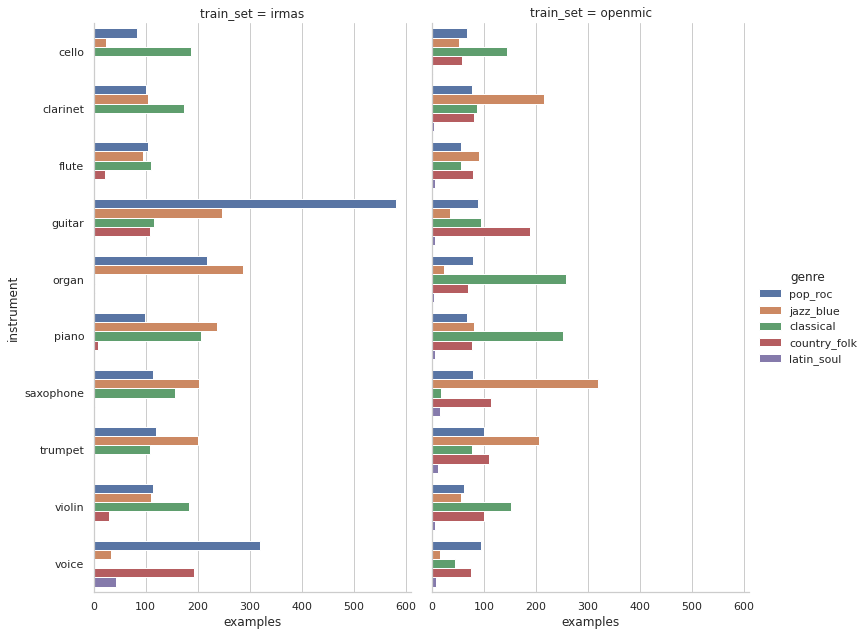

In [34]:
genre_inst = genre_inst[((genre_inst.genre != 'other'))]

sns.set_theme(context='notebook', style='whitegrid', palette='deep')
sns.catplot(data=genre_inst, col='train_set', y='instrument', x='examples', hue='genre', kind='bar', height=9, aspect=.6);
plt.savefig('genre_information.png')